<a href="https://colab.research.google.com/github/pbenito1/TFM/blob/main/2_ML_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install auto-sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.5 MB 5.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 24.9 MB 1.5 MB/s 
     |████████████████████████████████| 4.4 MB 63.5 MB/s 
     |████████████████████████████████| 260 kB 68.1 MB/s 
     |████████████████████████████████| 4.9 MB 66.5 MB/s 
     |████████████████████████████████| 46 kB 4.0 MB/s 
  Created wheel for auto-sklearn: filename=auto_sklearn-0.15.0-py3-none-any.whl size=6641945 sha256=d4d20045e35c80efd5d127c1c415122167a719c24f75ace3a3ceb32246f86f91
  Stored in directory: /root/.cache/pip/wheels/c5/11/0e/aeac2cee929fa4388e528737b49deb2eea05486e6f80d61c1a
  Created wheel for pynisher: filename=pynisher-0.6.4-py3-none-any.whl size=7044 sha256=8edf0d5104878466282a10eef9dfe9d939978f8681fe6207c3fec678f34e5ef6
  Sto

In [4]:
# Imports
import re
import os
from collections import Counter
import pandas as pd
from math import log
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn import ensemble
from sklearn import feature_extraction
from sklearn.model_selection import train_test_split
#from sklearn.metrics import f1_score, accuracy_score, recall_score, confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import f1_score, accuracy_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score,train_test_split, GridSearchCV
import autosklearn.classification
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Clasificadores

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz




%matplotlib inline

In [47]:
# Estilos seaborn
sns.set(rc={"figure.dpi":200, 'savefig.dpi':200})
sns.set_context('notebook')
sns.set_style("ticks")

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

In [6]:
def custom_cm(cf_matrix):
  # Ref: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
  group_names = ['TN','FP','FN','TP']
  group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [7]:
# Cargamos datos
DATASET_PATH='/content/drive/MyDrive/TFM/data_processed/dga.csv'
df = pd.read_csv(DATASET_PATH,index_col=0)

In [8]:
df.sample(10)

,domain,family,category,tld,sld,subdomains_number,digits,length,num_dashes,entropy,ratio_vc,3gram,4gram,5gram,6gram
146604,fmeoakckceedcfck.com,padcrypt,malign,com,fmeoakckceedcfck,2,0,16,0,2.780639,0.454545,14,9,1,0
582836,freemusicarchive.org,benign,benign,org,freemusicarchive,2,0,16,0,3.327820,0.777778,14,13,12,11
149800,dnbfnmoekfdbenla.cc,padcrypt,malign,cc,dnbfnmoekfdbenla,2,0,16,0,3.202820,0.333333,14,7,1,0
918247,myefox.pl,benign,benign,pl,myefox,2,0,6,0,2.584963,0.500000,4,3,2,1
557398,gorollufoww.com,vawtrak,malign,com,gorollufoww,2,0,11,0,2.663533,0.571429,9,6,4,1
599274,nfrance.com,benign,benign,com,nfrance,2,0,7,0,2.521641,0.400000,5,4,3,2
1142395,xmytjs.com,benign,benign,com,xmytjs,2,0,6,0,2.584963,0.000000,4,3,2,1
804867,letsbookmarkit.com,benign,benign,com,letsbookmarkit,2,0,14,0,3.378783,0.555556,12,11,10,9
423,a2408cbf6aebb20c5b036ee54198f91a.cz.cc,bamital,malign,cc,cz,3,0,2,0,1.000000,0.000000,0,0,0,0
438065,smjvvzsekrprhnzy.net,murofet,malign,net,smjvvzsekrprhnzy,2,0,16,0,3.500000,0.066667,14,6,0,0


In [ ]:
# Aplicamos *one-hot encoding* a la variable TLD
# df = pd.concat([df, pd.get_dummies(df['tld'])], axis=1)

# WARN: Aunque es posible aplicar one-hot encoding, luego no es posible 
# aplicar algoritmos de machine learning porque da fallo de memoria

Eliminamos las variables tipo texto y los n-gramas

In [25]:
y = df['category']
X = df.drop(['family','category','domain','tld','sld','3gram','4gram','5gram','6gram',], axis=1)

Aplicamos a las variables restantes un escalado estandar, en el cual a cada columna se le resta la media de esa columna y se le divide por su desviación típica. Utilizamos para ello la función `StandarScaler` de la librería `sklearn`:

In [39]:
X_std_scaler = StandardScaler().fit_transform(X)
X_std = pd.DataFrame(X_std_scaler, index=X.index, columns=X.columns)

Realizamos un muestreo estratificado en función de la familia.

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['family'])
X_train_std, X_test_std, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['family'])

# Reducción de la dimensionalidad con análisis de componentes principales (PCA)

Para poder visualizar los resultados de los clasificaddores, realizaremos una reducción de la dimensionalidad utilizando PCA

In [41]:
pca2 = PCA(n_components=2)

pca = pca2.fit_transform(X_std)
pca_df = pd.DataFrame(data = pca, columns = ['PC1', 'PC2'])

Visualización de los datos

Text(0.5, 1.0, 'PCA')

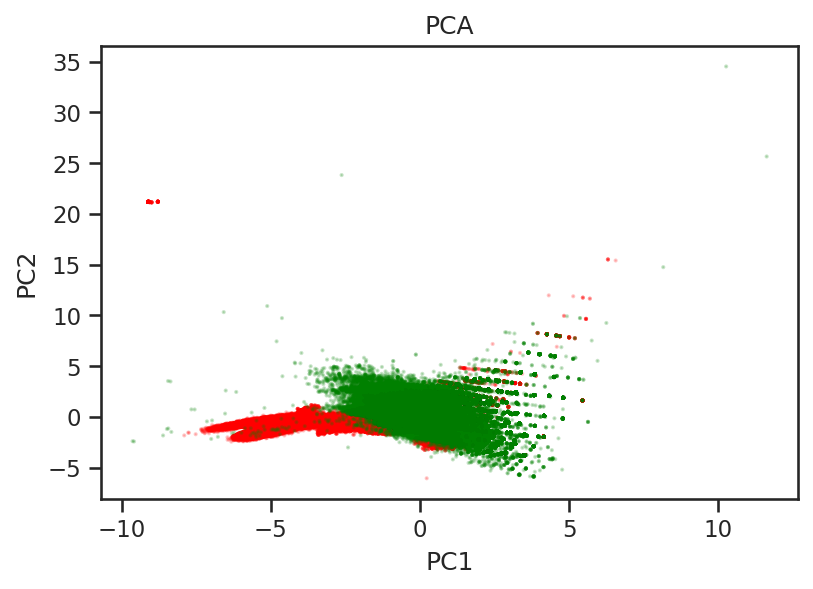

In [42]:
colors = {'malign':'red', 'benign':'green'}
plt.scatter(pca_df['PC1'].tolist(), 
            pca_df['PC2'].tolist(),
            alpha=0.2,
            s=1,
            c=y.map(colors))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("PCA")

#$k$-nn (_K Nearest Neighbours_)



In [11]:
grid_params={'n_neighbors': [2],
             'weights': ['uniform','distance']}
gs=GridSearchCV(
    KNeighborsClassifier(),
    grid_params,
    verbose = 1,
    cv=4,
    n_jobs=-1)

gs_results=gs.fit(X_train,y_train)
print(gs_results.best_params_)

Fitting 4 folds for each of 2 candidates, totalling 8 fits


KeyboardInterrupt: ignored

# Arbol de decision

In [24]:
type(y_train)

pandas.core.series.Series

In [36]:
df[df['category']=='benign'].describe()

,subdomains_number,digits,length,num_dashes,entropy,ratio_vc,3gram,4gram,5gram,6gram
count,571268.000000,571268.000000,571268.000000,571268.000000,571268.000000,571268.000000,571268.000000,571268.000000,571268.000000,571268.000000
mean,2.071473,0.189065,9.918824,0.121488,2.779243,0.596386,7.918887,6.920575,5.940865,5.008919
std,0.259374,0.767918,4.267554,0.375681,0.507418,0.336913,4.267430,4.264495,4.233788,4.144850
min,2.000000,0.000000,1.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,7.000000,0.000000,2.503258,0.400000,5.000000,4.000000,3.000000,2.000000
50%,2.000000,0.000000,9.000000,0.000000,2.845351,0.571429,7.000000,6.000000,5.000000,4.000000
75%,2.000000,0.000000,12.000000,0.000000,3.128085,0.750000,10.000000,9.000000,8.000000,7.000000
max,4.000000,39.000000,63.000000,25.000000,4.638563,19.666667,61.000000,60.000000,59.000000,58.000000


In [37]:
df[df['category']=='malign'].describe()

,subdomains_number,digits,length,num_dashes,entropy,ratio_vc,3gram,4gram,5gram,6gram
count,571268.000000,571268.000000,571268.000000,571268.000000,571268.000000,571268.000000,571268.000000,571268.000000,571268.000000,571268.000000
mean,2.044877,2.578683,13.889863,0.017001,3.054487,0.314770,11.025713,4.202940,1.242550,0.561467
std,0.207043,5.412918,7.597795,0.467018,0.598991,0.312404,6.657508,3.771575,2.942663,1.972232
min,2.000000,0.000000,2.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,9.000000,0.000000,2.750000,0.111111,6.000000,1.000000,0.000000,0.000000
50%,2.000000,0.000000,12.000000,0.000000,3.095795,0.230769,10.000000,3.000000,0.000000,0.000000
75%,2.000000,3.000000,16.000000,0.000000,3.454822,0.444444,14.000000,6.000000,1.000000,0.000000
max,4.000000,30.000000,54.000000,26.000000,4.879506,9.000000,52.000000,28.000000,24.000000,22.000000


Cross validation score para el conjunto de entrenamiento: 0.7883150171808939
Accuracy para el conjunto de test: 0.7882699949235913


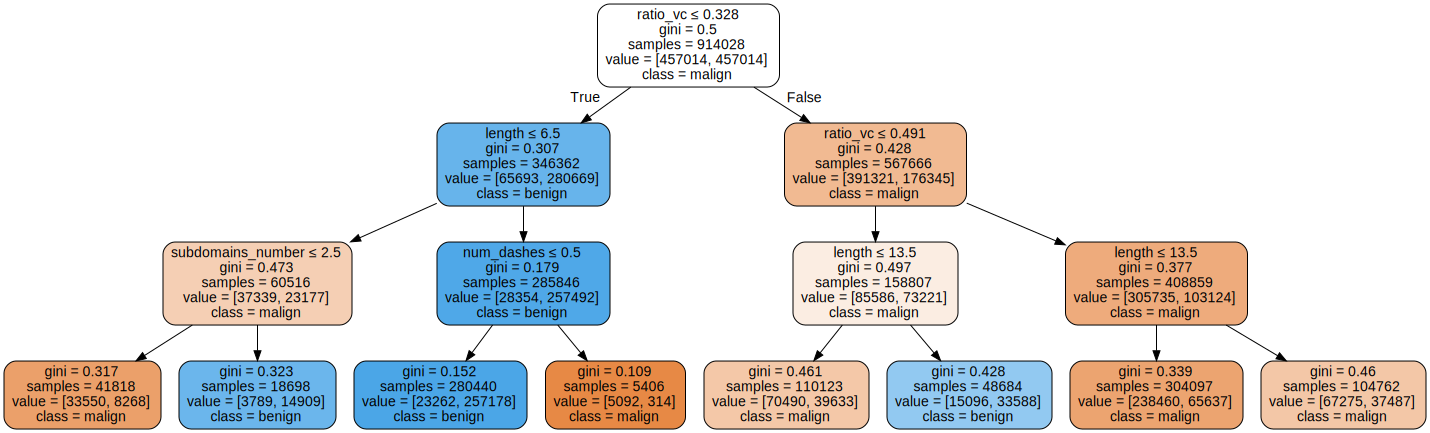

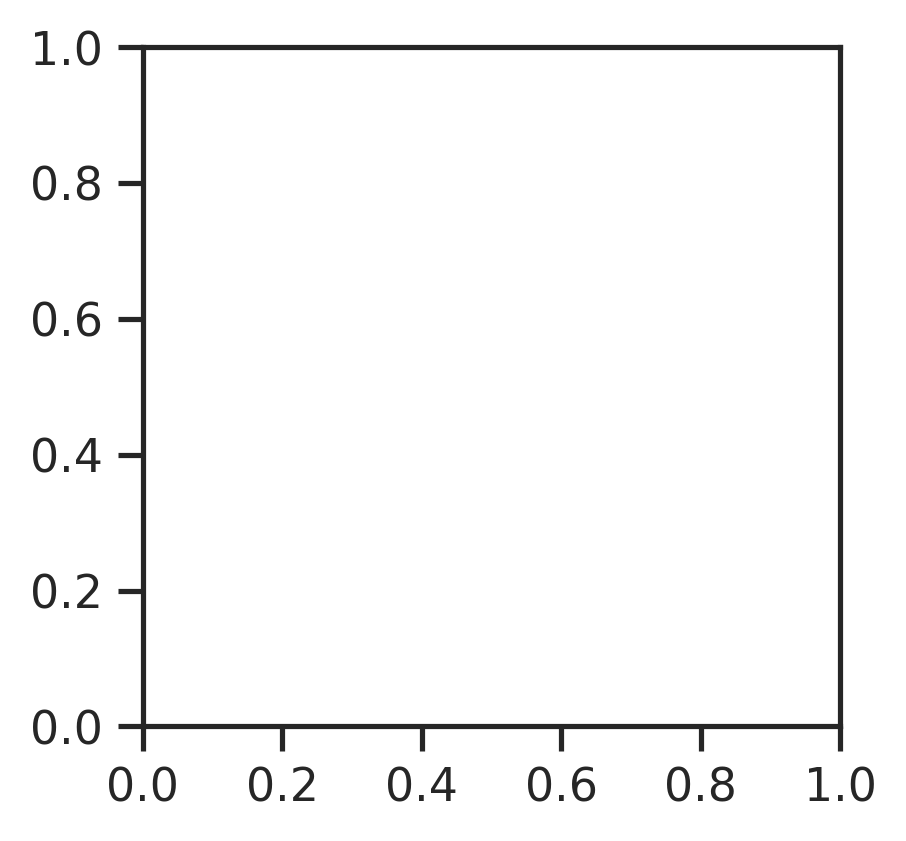

In [61]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
import graphviz 
# Instanciamos DecisionTreeClassifier de sklearn
dt_cls = DecisionTreeClassifier(max_depth = 3,  # Máxima profundidad del árbol
                             random_state = 42) # Semilla pseudoaleatorios
# Entrenamos el modelo
dt_cls.fit(X_train, y_train)

# Representamos el arbol
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (3,3), dpi=300)
'''
tree.plot_tree(dt_cls,feature_names = X_train.columns, 
               class_names=['malign','benign'],
               filled = True,ax=axes);
'''

crossv=cross_val_score(dt_cls, X_train, y_train, cv = 5).mean()
print ("Cross validation score para el conjunto de entrenamiento: "+str(crossv))

y_test_pred = dt_cls.predict(X_test)
print("Accuracy para el conjunto de test:", sklearn.metrics.accuracy_score(y_test, y_test_pred))

# Guardar como PDF el Graphviz
'''
dot_data = tree.export_graphviz(dt_cls, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("dga_decision_tree") 
'''


dot_data = tree.export_graphviz(dt_cls, out_file=None, 
                                feature_names=X_train.columns,  
                                class_names=['malign','benign'],  
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

Dado que el algoritmod de clasificación `Decision Tree` facilita la interpretación visual, para entrenar el clasificador se han utilizado los datos sin estandarizar y se ha limitado la profundidad del árbol a 3 niveles.

El entrenamiento del clasificador ofrece un `accuracy`de 0,75. Se puede observar que las dos variables más significativas son el `ratio_vc` y `length`.

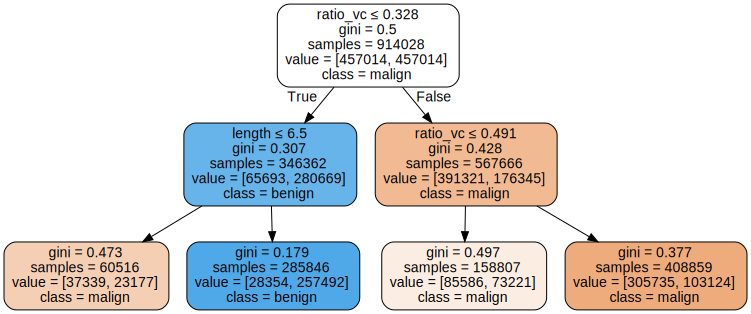

In [58]:

#dot_data = tree.export_graphviz(dt_cls, out_file=None) 
#graph = graphviz.Source(dot_data) 
#graph.render("iris")


# AutoML
La librería `auto-sklearn` nos permite evaluar de forma automática múltiples algoritmos de *machine learning* con diversos valores para sus correspondientes hiperparámetros. Asimismo, la librería construye un modelo compuesto tipo *ensemble*, en el que se utiliza una combinación de los mejorese modelos posibles.

La librería permite ajustar divesos parámetros, como el tiempo máximo que se desea dedicar al proceso completo (parámetro `time_left_for_this_task`), así como el tiempo máximo a dedicar para cada algoritmo de clasificación (parámetro `per_run_time_limit`). Por ejemplo:
```
AutoSklearnClassifier(
    time_left_for_this_task=5*60,
    per_run_time_limit=30
)
```

Asimismo es posible especificar que algoritmos de clasificación emplear y si se desea realizar algún preprocesamiento:
```
    automl = autosklearn.classification.AutoSklearnClassifier(
    include = {
        'classifier': ["gaussian_nb", "k_nearest_neighbors"],
        'feature_preprocessor': ["no_preprocessing"]
    },
    exclude=None
)
```

Ref: [Let the Script Find Out the ML Model that Outperforms Yours](https://towardsdatascience.com/python-automl-sklearn-fd85d3b3c5e)

In [ ]:
cls = autosklearn.classification.AutoSklearnClassifier()
cls.fit(X_train, y_train)
predictions = cls.predict(X_test)

[WARNING] [2022-11-26 10:17:57,775:Client-EnsembleBuilder] No runs were available to build an ensemble from


In [ ]:
y_test_pred = cls.predict(X_test)
print("Accuracy score:", sklearn.metrics.accuracy_score(y_test, y_test_pred))

Accuracy score: 0.8218618166541215


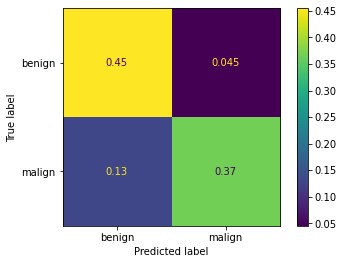

In [ ]:
ConfusionMatrixDisplay.from_estimator(cls, X_test, y_test,normalize='all')

In [ ]:
cls.leaderboard()

,rank,ensemble_weight,type,cost,duration
model_id,,,,,
3,1,0.90,gradient_boosting,0.176912,88.230625
7,2,0.08,mlp,0.198041,252.193568
13,3,0.02,sgd,0.253920,42.009745


En el *ensemble* generado se puede observar que el mayor peso se lo lleva el algoritmo `gradient_boosting` con un 90%, seguido de `mlp` (*Multi layer perceptron*, es decir, una red neuronal) con un 8% y `sgd` (*Stochastic gradient descent*), con un 2%. 

In [ ]:
cls.show_models()

{3: {'model_id': 3,
  'rank': 1,
  'cost': 0.17691211086430392,
  'ensemble_weight': 0.9,
  'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice at 0x7f5654e74190>,
  'balancing': Balancing(random_state=1, strategy='weighting'),
  'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice at 0x7f5654e37a10>,
  'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice at 0x7f5654dc1410>,
  'sklearn_classifier': HistGradientBoostingClassifier(early_stopping=False,
                                 l2_regularization=1.0945814167023392e-10,
                                 learning_rate=0.11042628136263043, max_iter=512,
                                 max_leaf_nodes=30, min_samples_leaf=22,
                                 n_iter_no_change=0, random_state=1,
                                 validation_fraction=None, warm_start=True)},
 7: {'model_id': 7,
  'rank': 2,
  'cost': 0.1

In [ ]:
type(automl_models.get(3).get('data_preprocessor'))

autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice

In [ ]:
automl_models=cls.show_models()
for k in automl_models.keys():
  print("Rank: ",automl_models.get(k).get('rank'))
  print("Classifier: ",automl_models.get(k).get('sklearn_classifier'))

Rank:  1
Classifier:  HistGradientBoostingClassifier(early_stopping=False,
                               l2_regularization=1.0945814167023392e-10,
                               learning_rate=0.11042628136263043, max_iter=512,
                               max_leaf_nodes=30, min_samples_leaf=22,
                               n_iter_no_change=0, random_state=1,
                               validation_fraction=None, warm_start=True)
Rank:  2
Classifier:  MLPClassifier(alpha=0.0013962942610192463, beta_1=0.999, beta_2=0.9,
              early_stopping=True, hidden_layer_sizes=(29,),
              learning_rate_init=0.001358401370818654, max_iter=128,
              n_iter_no_change=32, random_state=1, verbose=0, warm_start=True)
Rank:  3
Classifier:  SGDClassifier(alpha=1.6992296128865824e-07, average=True, eta0=0.01, loss='log',
              max_iter=256, penalty='l1', random_state=1,
              tol=1.535384699341134e-05, warm_start=True)


# Random Forest

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [ ]:
print("El accuracy del modelo Random Forest es:",rf.score(X_test, y_test))

El accuracy del modelo Random Forest es: 0.824583822010608


In [ ]:
plot_confusion_matrix(rf, X_test, y_test)

NameError: ignored

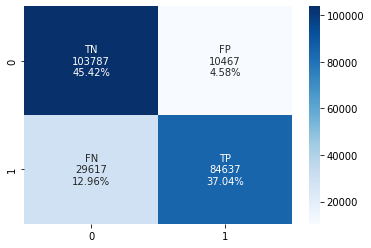

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred_rf)
custom_cm(cf_matrix)

In [ ]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

      benign       0.78      0.91      0.84    114254
      malign       0.89      0.74      0.81    114254

    accuracy                           0.82    228508
   macro avg       0.83      0.82      0.82    228508
weighted avg       0.83      0.82      0.82    228508

